# 0.0 IMPORTS

In [1]:
import random
import pickle

import numpy                   as np
import pandas                  as pd

import psycopg2                as pg
import sqlalchemy              as db

import seaborn                 as sns
import matplotlib.patches      as mpatches
import scikitplot              as skplt

from matplotlib                import pyplot as plt

from IPython.core.display      import HTML
from IPython.display           import Image

from pycorrcat.pycorrcat       import plot_corr, corr_matrix

from sklearn                   import preprocessing as pp
from sklearn.ensemble          import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model      import LogisticRegression
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.ensemble          import RandomForestClassifier
from lightgbm                  import LGBMClassifier

from sklearn                   import model_selection as ms
from sklearn.model_selection   import StratifiedKFold

## 0.1 Helper Functions

In [2]:
def personal_settings(): 

    display(HTML('<style>.container{width:98% !important;}</style>'))
    np.set_printoptions(suppress=True)
    pd.options.display.float_format = '{:.2f}'.format
    pd.options.mode.chained_assignment = None
    
    sns.set(rc={'figure.figsize':(22,10)})
    
    return None

def metrics_at_k(X, y, yhat, model_name, k):

    # copying data
    df_perf = X.copy()
    df_perf['response'] = y.copy()
    
    # propensity score
    df_perf['score'] = yhat[:,1]
        
    # sorting values
    df_perf = df_perf.sort_values(['score', 'response'], ascending=[False, False])
    df_perf = df_perf.reset_index(drop=True)
    
    df_perf['ranking']        = df_perf.index + 1
    df_perf['precision_at_k'] = df_perf['response'].cumsum() / df_perf['ranking']
    df_perf['recall_at_k']    = df_perf['response'].cumsum() / df_perf['response'].sum()
    
    precision = df_perf.loc[k, 'precision_at_k']
    recall    = df_perf.loc[k, 'recall_at_k']
    
    return pd.DataFrame({'Model'     : model_name,
                         'Precision' : precision,
                         'Recall'    : recall}, index=[0])


def cross_validation(X, y, model, model_name, nfold, k, verbose=False):
   
    kf = StratifiedKFold(n_splits=nfold, shuffle=True)
    result = pd.DataFrame()
    i = 1
    
    for train, test in kf.split(X, y):

        # model training
        model.fit(X.iloc[train,:], y.iloc[train])

        # model prediction
        yhat_model = model.predict_proba(X.iloc[test,:])

        result_at_k = metrics_at_k(X.iloc[test,:], y.iloc[test], yhat_model, model_name, k=k)
        result = pd.concat([result, result_at_k])
        
        if verbose:
            print( f'\nKFold Number: {i}/{nfold}') 
            i=i+1
            
    return pd.DataFrame({'Model': model_name,
                         'Precision': str(round(result['Precision'].mean(), 2)) + ' +/- ' + str(round(result['Precision'].std(), 4)),
                         'Recall'   : str(round(result['Recall'].mean(), 2))    + ' +/- ' + str(round(result['Recall'].std(), 4))}, index=[0])



In [3]:
personal_settings();

## 0.2 Load Data

In [4]:
# schema query
query_schema = """
SELECT nspname
FROM pg_catalog.pg_namespace pn;
"""

# table names query
query_table_names = """
SELECT tablename
FROM pg_catalog.pg_tables
WHERE schemaname = 'pa004';
"""

# querie for join the tables
query_join_tables = """
SELECT * 
FROM PA004.users AS u INNER JOIN PA004.vehicle AS v ON u.id = v.id
INNER JOIN PA004.insurance AS i ON i.id = u.id;
"""

In [5]:
#host = host
#port = port
#username = username
#password = password
#database = database
#
#str_connect = 'postgresql://' + username + ':' + password + '@' + host + ':' + port + '/' + database
#
#engine = db.create_engine(str_connect)
#conn   = engine.connect()
#
#df_raw = pd.read_sql(query_join_tables, conn)
#conn.close()

In [6]:
## drop duplicates columns (id)
# df_raw = df_raw.loc[:,~df_raw.columns.duplicated()].copy()
#
## save data as csv
##df_raw.to_csv('data/df_raw.csv', index=False)

In [7]:
df_raw = pd.read_csv('../data/df_raw.csv')

# 1 DATA DESCRIPTION

In [8]:
df1 = df_raw.copy()

In [9]:
df1.sample(5)

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
201939,88232,Female,37,8.00,124.00,1,1-2 Year,No,1,2630.00,141,0
271283,261808,Male,39,28.00,124.00,1,1-2 Year,Yes,0,24873.00,258,1
282320,350394,Female,48,36.00,124.00,1,1-2 Year,No,1,45493.00,270,0
79630,254566,Female,24,41.00,152.00,1,< 1 Year,No,1,34827.00,263,0
339686,48776,Female,34,28.00,26.00,1,1-2 Year,Yes,0,27402.00,15,1


## 1.1 Data Dimensions

In [10]:
print(df1.shape[0], 'rows')
print(df1.shape[1], 'columns')

381109 rows
12 columns


## 1.2 Data Descriptions

* `id` | unique ID for the customer.   
* `gender` | gender of the customer.   
* `age` | age of the customer.   
* `driving_license` | `0` customer does not have DL and `1` customer already has DL.    
* `region_code` | unique code for the region of the customer.    
* `previously_insured`  | `1` customer already has vehicle insurance and `0` customer doesn't have vehicle insurance    
* `vehicle_age` | age of the vehicle.    
* `vehicle_damage` | `1` customer got his/her vehicle damaged in the past and  `0` customer didn't get his/her vehicle damaged in the past.    
* `anual_premium` | the amount customer needs to pay as premium in the year.    
* `policy_sales_channel` | anonymized code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.    
* `vintage` | number of days, customer has been associated with the company.    
* `response` |  `1` customer is interested and `0` customer is not interested.

## 1.3 Data Types

In [11]:
description = []

for i in df1.columns:
    description.append([
        i,
        df1[i].dtypes,
        df1[i].nunique(),
        df1[i].drop_duplicates().sample(2).values
    ])

pd.DataFrame(data = description, columns=['attributes', 'dtypes', 'nunique', 'sample'])

,attributes,dtypes,nunique,sample
0,id,int64,381109,"[28640, 222992]"
1,gender,object,2,"[Female, Male]"
2,age,int64,66,"[39, 27]"
3,region_code,float64,53,"[34.0, 22.0]"
4,policy_sales_channel,float64,155,"[66.0, 7.0]"
5,driving_license,int64,2,"[0, 1]"
6,vehicle_age,object,3,"[> 2 Years, < 1 Year]"
7,vehicle_damage,object,2,"[No, Yes]"
8,previously_insured,int64,2,"[0, 1]"
9,annual_premium,float64,48838,"[30095.0, 25151.0]"


## 1.4 NA Checking and Treatment

In [12]:
description = []

for i in df1.columns:
    description.append([
        i,
        df1[i].isna().sum(),
        round((df1[i].isna().sum()/len(df1))*100)
    ])

pd.DataFrame(data = description, columns=['attributes','null', '%null'])

,attributes,null,%null
0,id,0,0
1,gender,0,0
2,age,0,0
3,region_code,0,0
4,policy_sales_channel,0,0
5,driving_license,0,0
6,vehicle_age,0,0
7,vehicle_damage,0,0
8,previously_insured,0,0
9,annual_premium,0,0


## 1.5 Descriptive Statistics

In [13]:
df_num1 = df1.select_dtypes(include=['int64', 'float64'])
df_cat1 = df1.select_dtypes(include='object')

### 1.5.1 Numerical Attributes

In [14]:
describe_num1 = df_num1.describe().T

describe_num1['range'] = (df_num1.max() - df_num1.min()).tolist()
describe_num1['skew'] = df_num1.skew().tolist()
describe_num1['kurtosis'] = df_num1.kurtosis().tolist()

describe_num1

,count,mean,std,min,25%,50%,75%,max,range,skew,kurtosis
id,381109.00,190555.00,110016.84,1.00,95278.00,190555.00,285832.00,381109.00,381108.00,-0.00,-1.20
age,381109.00,38.82,15.51,20.00,25.00,36.00,49.00,85.00,65.00,0.67,-0.57
region_code,381109.00,26.39,13.23,0.00,15.00,28.00,35.00,52.00,52.00,-0.12,-0.87
policy_sales_channel,381109.00,112.03,54.20,1.00,29.00,133.00,152.00,163.00,162.00,-0.90,-0.97
driving_license,381109.00,1.00,0.05,0.00,1.00,1.00,1.00,1.00,1.00,-21.60,464.35
previously_insured,381109.00,0.46,0.50,0.00,0.00,0.00,1.00,1.00,1.00,0.17,-1.97
annual_premium,381109.00,30564.39,17213.16,2630.00,24405.00,31669.00,39400.00,540165.00,537535.00,1.77,34.00
vintage,381109.00,154.35,83.67,10.00,82.00,154.00,227.00,299.00,289.00,0.00,-1.20
response,381109.00,0.12,0.33,0.00,0.00,0.00,0.00,1.00,1.00,2.30,3.30


* We observe a high kutosi for `driving_license` and an mean of 1, meaning that most customers has a driving license.
* The range o values of `annual_premium` is considerable, which indicates outliers. 
* In the `response`, the third quartile is 0, which means that most customers are not interested in car insurance.

### 1.5.2 Categorical Attributes

In [15]:
describe_cat1 = df_cat1.describe().T
describe_cat1

,count,unique,top,freq
gender,381109,2,Male,206089
vehicle_age,381109,3,1-2 Year,200316
vehicle_damage,381109,2,Yes,192413


# 2 FEATURE ENGINEERING

In [16]:
df2 = df1.copy()

## 2.1 Hypotesis Mind Map

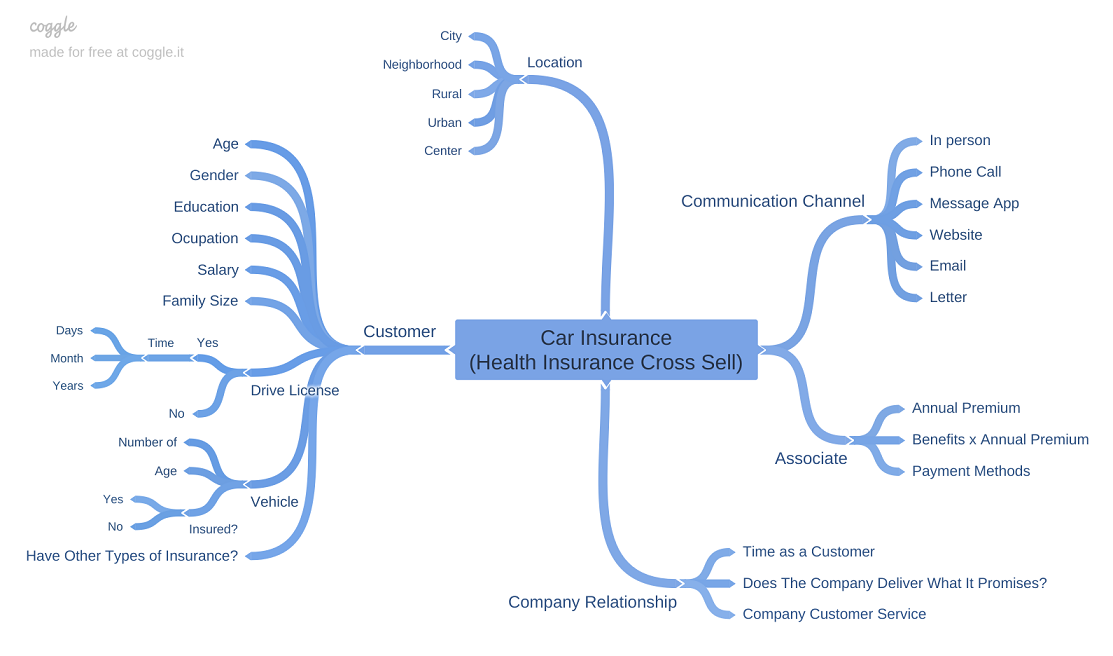

In [17]:
Image('../images/mind_map.png')

## 2.2 Hypothesis List

**H1.** Women are more interested in the car insurance than men.  
**H2.** The youngest and oldest customers are the least interested in the car insurance.    
**H3.** The region in which the costumer lives influence their interest in the car insurance.     
**H4.** The outreach channel influence the client's interest in the car insurance.      
**H5.** Customers with a driver's license at least 30% more interested in the car insurance than those who don't have one.     
**H6.** Customers with newer cars (up to 2 years) are more interested in the car insurance than customers with older cars.    
**H7.** Customers who have already damaged their vehicle are at least 20% more interested in the car insurance than those who have never damaged their vehicle.    
**H8.** A maximum of 30% of previously insured customers are interested in the car insurance.     
**H9.** Customers with a higher annual premium for health insurance are more interested in the car insurance than customers with a lower annual premium.    
**H10.** Customers insured in health for a long time are more interested in the insurance than those insured for a shorter period.     

## 2.3 Features Engineering

In [18]:
# vehicle_damage as number
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0).astype(np.int64)

# vehicle_age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )

# 3.0 Data Filtering and Split

## 3.1 Data Filtering

Nothing to filter.

## 3.2 Split Data

In [19]:
## setting the random seed 
#np.random.seed(11)
#
## split the data into training and validation/test
#split1 = np.random.choice(a=[0, 1], size=len(df2), replace=True, p=[0.8, 0.2]) 
#
#df_train = df2.loc[split1 == 0].reset_index(drop=True)
#df_train.to_csv('../data/df_train.csv', index=False)
#
#df_rem = df2.loc[split1 == 1].reset_index(drop=True)
#
## split the data into validation and test
#split2 = np.random.choice(a=[0, 1], size=len(df_rem), replace=True, p=[0.5, 0.5])
#
#df_valid = df_rem.loc[split2 == 0].reset_index(drop=True)
#df_valid.to_csv('../data/df_valid.csv', index=False)
#
#df_test = df_rem.loc[split2 == 1].reset_index(drop=True)
#df_test.to_csv('../data/df_test.csv', index=False)

# 4 EXPLORATORY DATA ANALYSIS

When it comes to classification problems, in EDA we try to find which features have a natural separation from the response variable. Looking from the linear algebra point of view, a classification algorithm seeks to find a separating hyperplane or a cut in space that can separate the classes. The hypotheses raised that we will try to validate have this purpose, and also generate some insights for the business.

In [20]:
df4 = pd.read_csv('../data/df_train.csv')

In [21]:
df_num2 = df4.select_dtypes(include = ['int64', 'float64'])
df_cat2 = df4.select_dtypes(include = 'object')

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

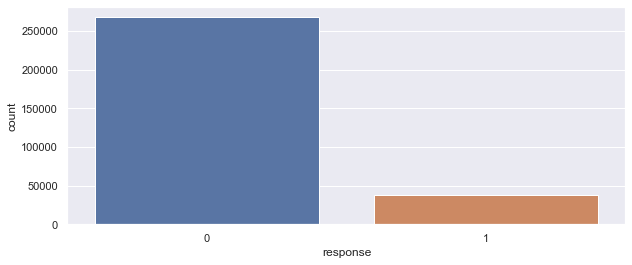

In [22]:
plt.figure(figsize=(10, 4))
sns.countplot(x='response', data=df4);

### 4.1.2 Numerical Variables

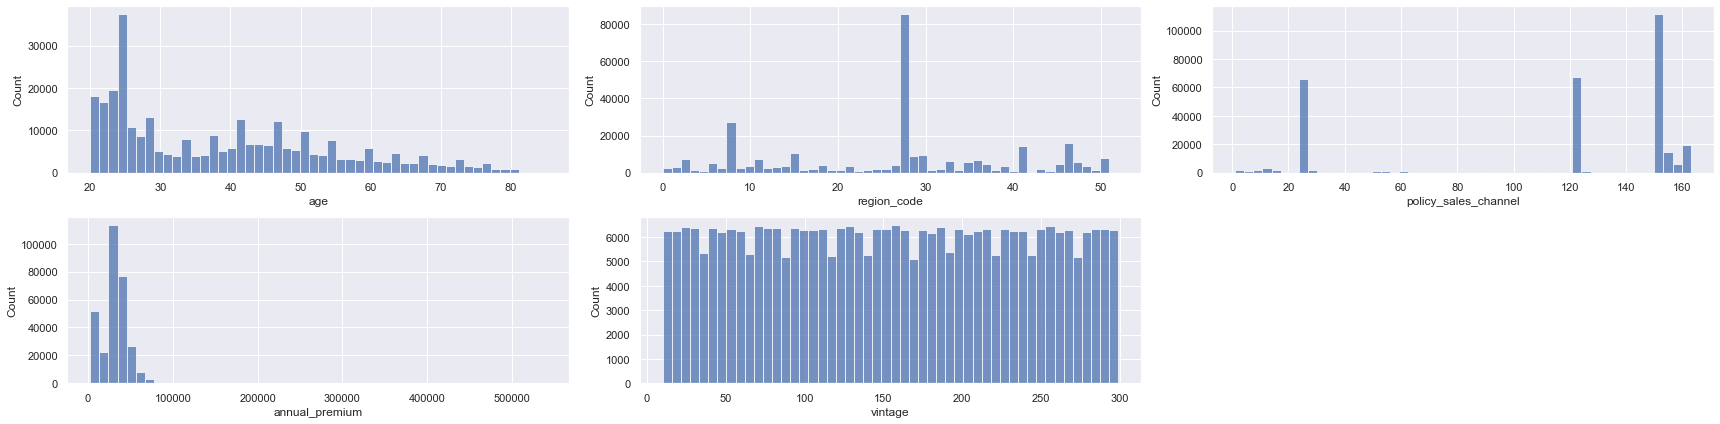

In [23]:
cols = 3
rows = 2
num_cols = df_num2[['age', 'region_code', 'policy_sales_channel', 'annual_premium', 'vintage']]
fig = plt.figure(figsize= (24, 6))

for i, col in enumerate(num_cols):
    ax=fig.add_subplot( rows, cols, i+1)
    sns.histplot(x=df_num2[col], bins=50, ax=ax)
    
fig.tight_layout()  
plt.show()

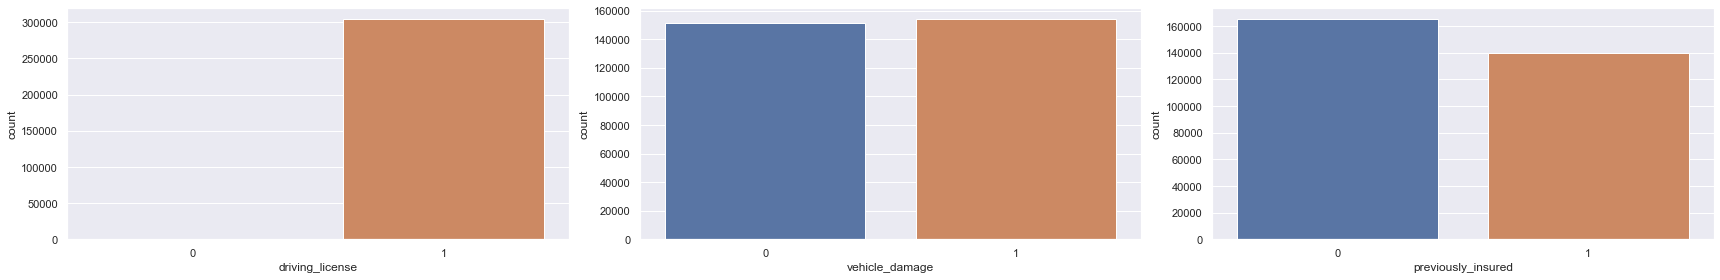

In [24]:
cols = 3
rows = 1
num_cols = df_num2[['driving_license', 'vehicle_damage', 'previously_insured']]
fig = plt.figure(figsize= (24, 4))

for i, col in enumerate(num_cols):
    ax=fig.add_subplot( rows, cols, i+1)
    sns.countplot(x=df_num2[col], ax=ax)
    
fig.tight_layout()  
plt.show()

### 4.1.3 Categorical Variables

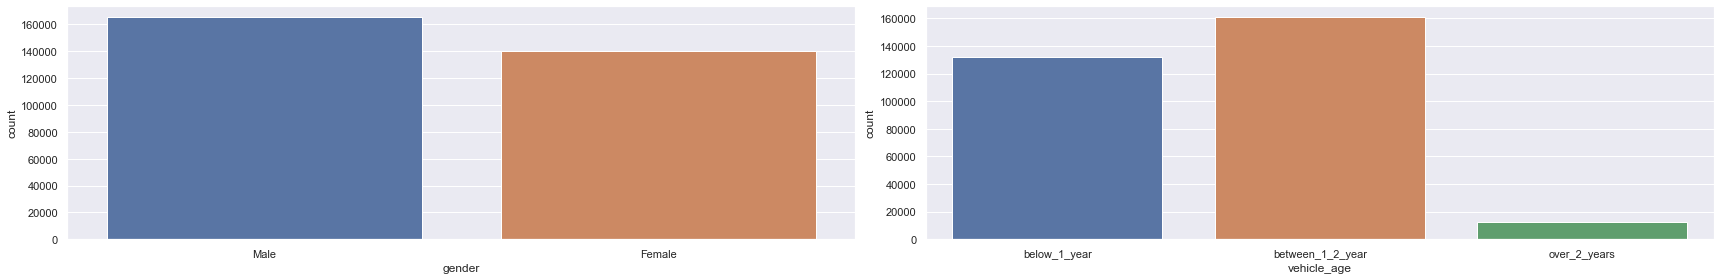

In [25]:
cols = 2
rows = 1
num_cols = df_cat2.columns
fig = plt.figure(figsize= (24, 4))

for i, col in enumerate(num_cols):
    ax=fig.add_subplot( rows, cols, i+1)
    sns.countplot(x=df_cat2[col], ax=ax)
    
fig.tight_layout()  
plt.show()

## 4.2 Bivariate Analysis

### H1. Women are more interested in the car insurance than men.     
**False**. While 10.37% of women are interested in the car insurance, 13.86% of men are.

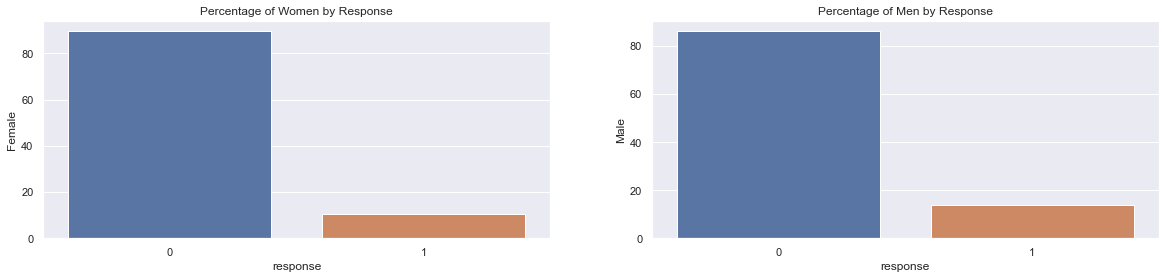

In [26]:
aux1 = pd.crosstab(df4['gender'], df4['response']).apply(lambda x: x / x.sum() * 100, axis=1)

# resetting the index and transposing to have answers and the genders as columns, to make the plots
aux2 = aux1.T.reset_index()

plt.figure(figsize= (20, 4))

plt.subplot(1, 2, 1)
sns.barplot(x='response', y='Female', data=aux2)
plt.title('Percentage of Women by Response');

plt.subplot(1, 2, 2)
sns.barplot(x='response', y='Male', data=aux2)
plt.title('Percentage of Men by Response');

In [27]:
aux1

response,0,1
gender,,
Female,89.63,10.37
Male,86.14,13.86


In [28]:
print(f'While {round(aux2.iloc[1,1], 2)}% of women are interested in the car insurance the car insurance, {round(aux2.iloc[1,2], 2)}% of men are.')

While 10.37% of women are interested in the car insurance the car insurance, 13.86% of men are.


We have that the number of customers by gender not interested in the company's car insurance with very close values, and the same thing happens with the customers interested by gender. This means that for the model the variable gender alone is probably non-discriminatory, i.e., it is probably not possible to cut into the space that separates by gender those who are interested from those who are not. 

### H2. The youngest and oldest customers are the least interested in the car insurance.
**True.** The youngest and oldest customers are the least interested in car insurance. The customers most interested in car insurance are between the ages of 31 and 50, with 36 to 40 being the ones with the highest interest.

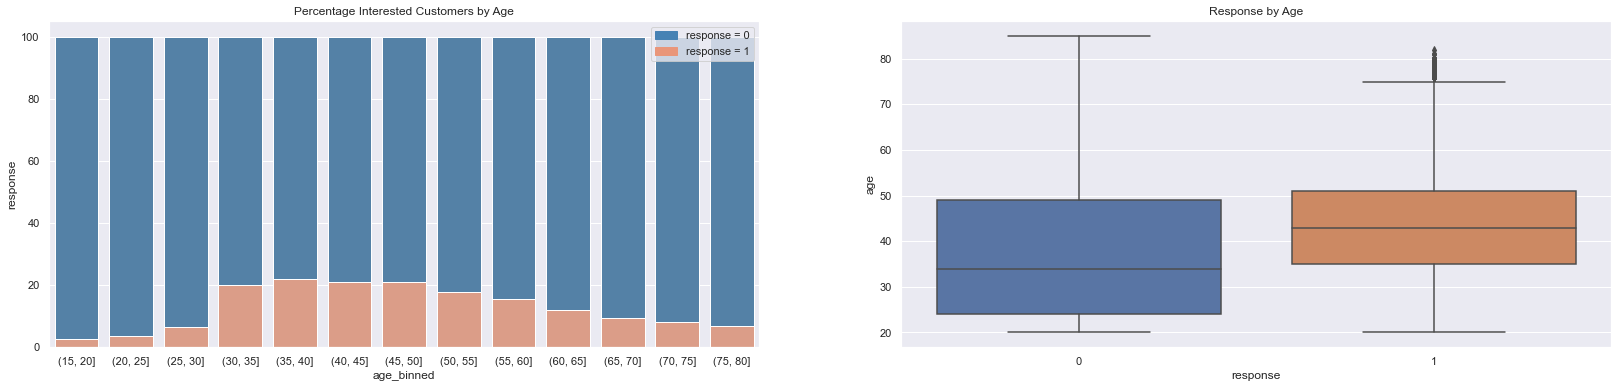

In [29]:
# define the age bins
bins = list(np.arange(15, 85, 5))

# response is 0 or 1 (total)
aux1 = df4[['age', 'response']]
aux1 ['age_binned'] = pd.cut(aux1['age'], bins=bins)
aux1 = aux1[['age_binned', 'response']].groupby('age_binned').count().reset_index()

# response is 1
aux2 = df4[['age', 'response']]
aux2['age_binned'] = pd.cut(aux2['age'], bins=bins)
aux2 = aux2[['age_binned', 'response']].groupby('age_binned').sum().reset_index()

# convert response in percentage in relation to the total in aux2 and aux1
aux2['response'] = [i / j * 100 for i,j in zip(aux2['response'], aux1['response'])]
aux1['response'] = [i / j * 100 for i,j in zip(aux1['response'], aux1['response'])]


# plots
plt.figure(figsize=(28, 6))

# percent stacked barplot age by response
plt.subplot(1, 2, 1)
# bar chart 1 -> top bars (group of 'response = 0')
bar1 = sns.barplot(x='age_binned',  y='response', data=aux1, color='steelblue')

# bar chart 2 -> bottom bars (group of 'response = 1')
bar2 = sns.barplot(x='age_binned', y='response', data=aux2, color='darksalmon')

# add legend
top_bar = mpatches.Patch(color='steelblue', label='response = 0')
bottom_bar = mpatches.Patch(color='darksalmon', label='response = 1')
plt.legend(handles=[top_bar, bottom_bar])
plt.title('Percentage Interested Customers by Age')

# boxplot age by response
plt.subplot(1, 2, 2)
sns.boxplot( x='response', y='age', data=df4)
plt.title('Response by Age');

The youngest and oldest customers are the least interested in car insurance as we can see in the first plot. The customers most interested in car insurance are between the ages of 31 and 50, with 36 to 40 being the ones with the highest interest.

Analyzing the utility of the variable age for the model, we have that, the median age of customers interested in car insurance is higher than those who are not interested, and the first quartile of interested customers is higher than the median of customers who are not interested, indicating that the distribution is skewed, which can also be seen in the first plot. This indicates that the age variable is probably useful for the model.

### H3. The region in which the costumer lives influence their interest in the car insurance.
**True.** Although the difference between the percentage of customers interested and not interested in car insurance by region code is slight, it does exist.

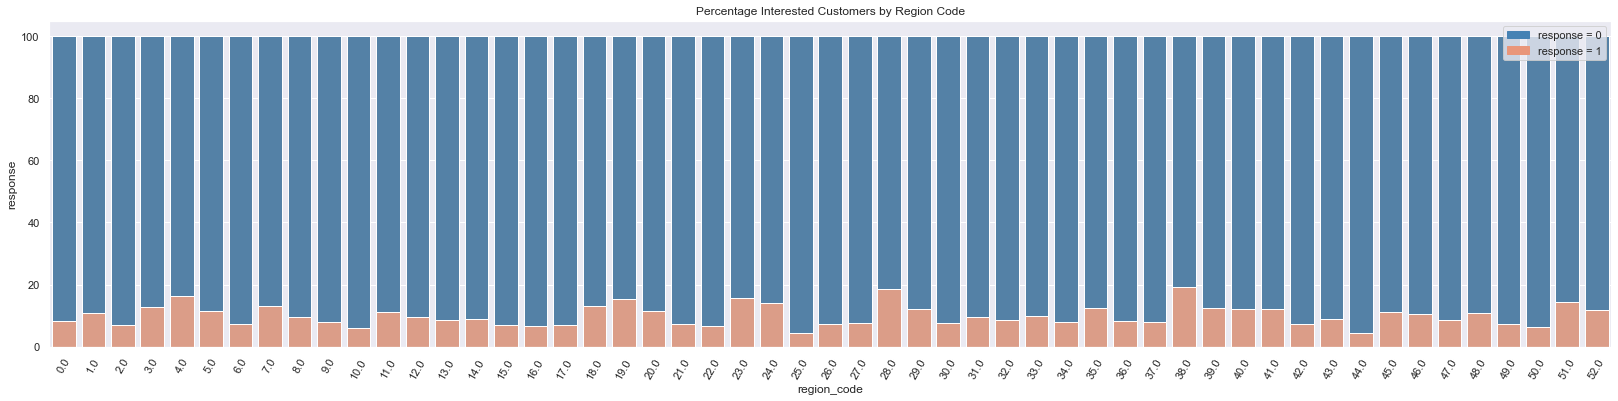

In [30]:
# response is 0 or 1 (total)
aux1 = df4[['region_code', 'response']].groupby(['region_code']).count().reset_index()

# response is 1
aux2 = df4[['region_code', 'response']].groupby(['region_code']).sum().reset_index()

# convert response in percetage in relation to the total in aux2 and aux1
aux2['response'] = [i / j * 100 for i,j in zip(aux2['response'], aux1['response'])]
aux1['response'] = [i / j * 100 for i,j in zip(aux1['response'], aux1['response'])]

# percent stacked barplot 
plt.figure(figsize=(28, 6))

# bar chart 1 -> top bars (group of 'response = 0')
bar1 = sns.barplot(x='region_code',  y='response', data=aux1, color='steelblue')

# bar chart 2 -> bottom bars (group of 'response = 1')
bar2 = sns.barplot(x='region_code', y='response', data=aux2, color='darksalmon')

# add legend
top_bar = mpatches.Patch(color='steelblue', label='response = 0')
bottom_bar = mpatches.Patch(color='darksalmon', label='response = 1')
plt.legend(handles=[top_bar, bottom_bar])
plt.title('Percentage Interested Customers by Region Code')
plt.xticks(rotation=60);

Although the difference between the percentage of customers interested and not interested in auto insurance by region code is slight, it exists, validating our hypothesis, and also showing that the variable might be useful for the model.

### H4. The outreach channel influence the client's interest in the car insurance. 
**True.** There are many ineffective contact channels. While others concentrate most of the customers interested in the car insurance.

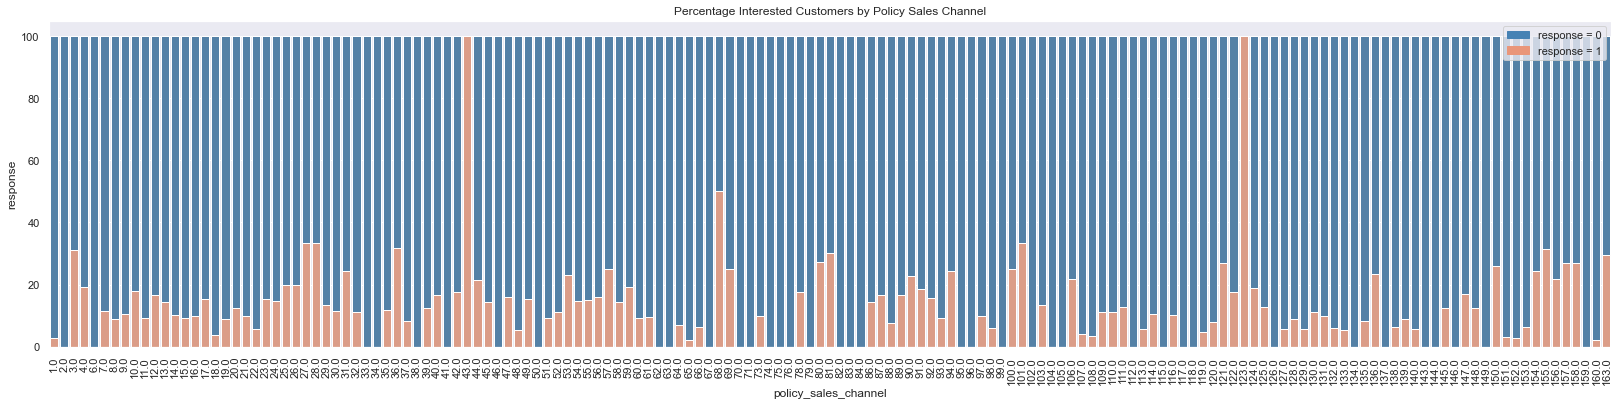

In [31]:
# response is 0 or 1 (total)
aux1 = df4[['policy_sales_channel', 'response']].groupby(['policy_sales_channel']).count().reset_index()

# response is 1
aux2 = df4[['policy_sales_channel', 'response']].groupby(['policy_sales_channel']).sum().reset_index()

# convert response in percetage in relation to the total in aux2 and aux1
aux2['response'] = [i / j * 100 for i,j in zip(aux2['response'], aux1['response'])]
aux1['response'] = [i / j * 100 for i,j in zip(aux1['response'], aux1['response'])]

# percent stacked barplot
plt.figure(figsize=(28, 6))

# bar chart 1 -> top bars (group of 'response = 0')
bar1 = sns.barplot(x='policy_sales_channel',  y='response', data=aux1, color='steelblue')

# bar chart 2 -> bottom bars (group of 'response = 1')
bar2 = sns.barplot(x='policy_sales_channel', y='response', data=aux2, color='darksalmon')

# add legend
top_bar = mpatches.Patch(color='steelblue', label='response = 0')
bottom_bar = mpatches.Patch(color='darksalmon', label='response = 1')
plt.legend(handles=[top_bar, bottom_bar])
plt.title('Percentage Interested Customers by Policy Sales Channel')
plt.xticks(rotation=90);

There are many ineffective contact channels. While others concentrate most of the customers interested in car insurance. In addition to validating our hypothesis, this also indicates that the policy sales channel variable is probably useful for the model.

### H5. Customers with a driver's license at least 30% more interested in the car insurance than those who don't have one.   
**False.** Customers with a driver's license are 7.79% more interested in car insurance than those who don't have one. 

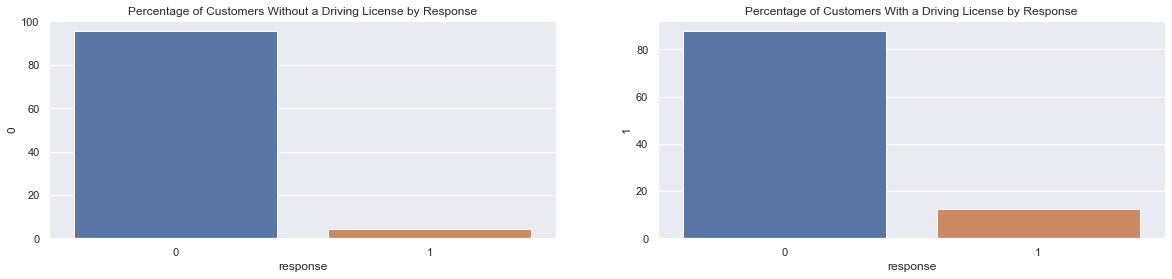

In [32]:
aux1 = pd.crosstab(df4['driving_license'], df4['response']).apply(lambda x: x / x.sum() * 100, axis=1)

# resetting the index and transposing to have answers and the genders as columns, to make the plots
aux2 = aux1.T.reset_index()

plt.figure(figsize= (20, 4))

plt.subplot(1, 2, 1)
sns.barplot(x='response', y=0, data=aux2)
plt.title('Percentage of Customers Without a Driving License by Response')

plt.subplot(1, 2, 2)
sns.barplot(x='response', y=1, data=aux2)
plt.title('Percentage of Customers With a Driving License by Response');

In [33]:
aux1

response,0,1
driving_license,,
0,95.52,4.48
1,87.73,12.27


In [34]:
print(f'While {round(aux2.iloc[1,1], 2)}% of customers without a driving license are interest in car insurance, {round(aux2.iloc[1,2], 2)}% of customers with a driving license are. So the difference between them is {round(aux2.iloc[1,2] - aux2.iloc[1,1], 2)}%.')

While 4.48% of customers without a driving license are interest in car insurance, 12.27% of customers with a driving license are. So the difference between them is 7.79%.


There are very close values for the response variable for customers who have a license to drive to those who do not -- the difference between those interested with a license to drive and those not is only 7.79%.
For the model, the driver's license variable can be useful by giving an indication, but it does not solve the problem by itself.

### H6. Customers with newer cars (up to 2 years) are more interested in the car insurance than customers with older cars. 
**False.** Customers with cars older than 2 years are more interested in car insurance.

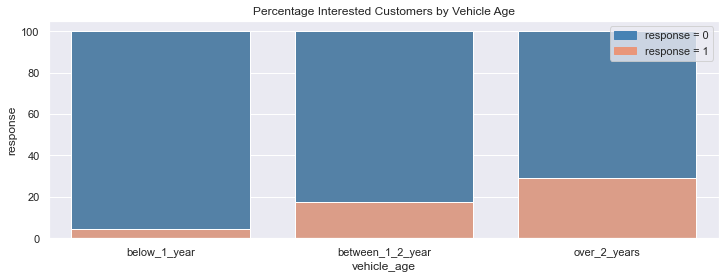

In [35]:
# response is 0 or 1 (total)
aux1 = df4[['vehicle_age', 'response']].groupby(['vehicle_age']).count().reset_index()

# response is 1
aux2 = df4[['vehicle_age', 'response']].groupby(['vehicle_age']).sum().reset_index()

# convert response in percetage in relation to the total in aux2 and aux1
aux2['response'] = [i / j * 100 for i,j in zip(aux2['response'], aux1['response'])]
aux1['response'] = [i / j * 100 for i,j in zip(aux1['response'], aux1['response'])]

# percent stacked barplot
plt.figure(figsize=(12, 4))

# bar chart 1 -> top bars (group of 'response = 0')
bar1 = sns.barplot(x='vehicle_age',  y='response', data=aux1, color='steelblue')

# bar chart 2 -> bottom bars (group of 'response = 1')
bar2 = sns.barplot(x='vehicle_age', y='response', data=aux2, color='darksalmon')

# add legend
top_bar = mpatches.Patch(color='steelblue', label='response = 0')
bottom_bar = mpatches.Patch(color='darksalmon', label='response = 1')
plt.legend(handles=[top_bar, bottom_bar])
plt.title('Percentage Interested Customers by Vehicle Age');

In [36]:
aux1 = pd.crosstab(df4['vehicle_age'], df4['response']).apply(lambda x: x / x.sum() * 100, axis=1)
aux1

response,0,1
vehicle_age,,
below_1_year,95.63,4.37
between_1_2_year,82.61,17.39
over_2_years,70.74,29.26


Surprisingly, customers with cars older than 2 years are more interested in auto insurance, invalidating our hypothesis.  Looks like vehicle age variable is probably useful for the model.

### H7.  Customers who have already damaged their vehicle are at least 20% more interested in the car insurance than those who have never damaged their vehicle.
**True.** While just 0.52% of customers who have never damaged their vehicle are interest in car insurance, 23.77% of who have already damaged their vehicle are.

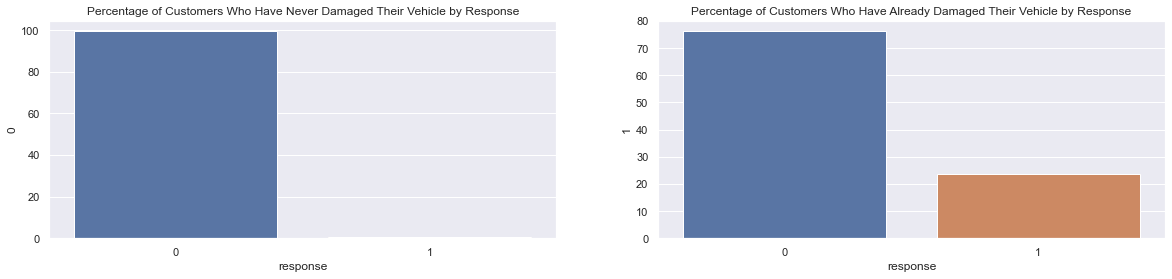

In [37]:
aux1 = pd.crosstab(df4['vehicle_damage'], df4['response']).apply(lambda x: x / x.sum() * 100, axis=1)

# resetting the index and transposing to have answers and the genders as columns, to make the plots
aux2 = aux1.T.reset_index()

plt.figure(figsize= (20, 4))

plt.subplot(1, 2, 1)
sns.barplot(x='response', y=0, data=aux2)
plt.title('Percentage of Customers Who Have Never Damaged Their Vehicle by Response')

plt.subplot(1, 2, 2)
sns.barplot(x='response', y=1, data=aux2)
plt.title('Percentage of Customers Who Have Already Damaged Their Vehicle by Response');

In [38]:
aux1

response,0,1
vehicle_damage,,
0,99.48,0.52
1,76.23,23.77


In [39]:
print(f'While just {round(aux2.iloc[1,1], 2)}% of customers who have never damaged their vehicle are interest in car insurance, {round(aux2.iloc[1,2], 2)}% of who have already damaged their vehicle are. So the difference between them is {round(aux2.iloc[1,2] - aux2.iloc[1,1], 2)}%.')

While just 0.52% of customers who have never damaged their vehicle are interest in car insurance, 23.77% of who have already damaged their vehicle are. So the difference between them is 23.25%.


Of the customers who have never damaged their car, less than 1% have an interest in acquiring insurance from the company. This maybe be a good insight to the business. 

In terms of our model, as the vehicle damage variable looks strongly related to the response, maybe this variable generates data leakage -- for the model it is almost certain that if the customer has never damaged the car the customer doesn't want our insurance (99.48%). 

### H8. A maximum of 30% of previously insured customers are interested in the car insurance. 
**True.** Of the customers previously insured, less than 1% have interest in the car insurance.

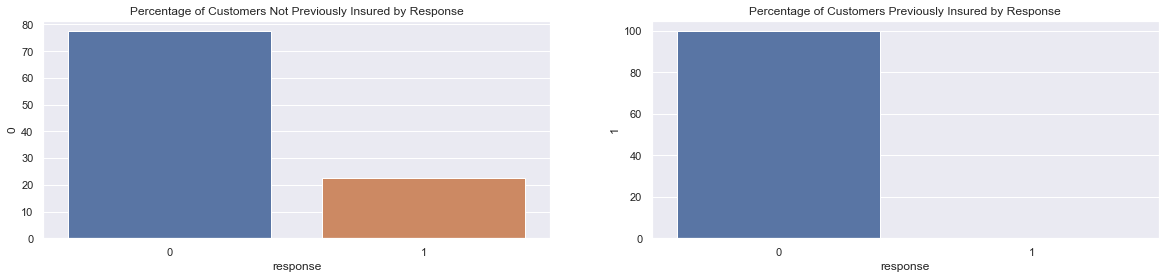

In [40]:
aux1 = pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x / x.sum() * 100, axis=1)

# resetting the index and transposing to have answers and the genders as columns, to make the plots
aux2 = aux1.T.reset_index()

plt.figure(figsize= (20, 4))

plt.subplot(1, 2, 1)
sns.barplot(x='response', y=0, data=aux2)
plt.title('Percentage of Customers Not Previously Insured by Response')

plt.subplot(1, 2, 2)
sns.barplot(x='response', y=1, data=aux2)
plt.title('Percentage of Customers Previously Insured by Response');

In [41]:
aux1

response,0,1
previously_insured,,
0,77.45,22.55
1,99.91,0.09


Of the customers who already have car insurance, less than 1% have an interest in the company's car insurance, i.e. switching insurers. This may be a good insight for the company -- marketing can make a tempting offer that makes these customers switch car insurance companies.

In terms of our model, it is the same that happened with the vehicle damage variable, as this variable looks strongly related to the response, maybe this variable generates data leakage.

### H9. Customers with a higher annual premium for health insurance are more interested in the car insurance than customers with a lower annual premium. 
**False.** With a few exceptions, interested customers are distributed somewhat evenly over different amounts of annual premiums. 

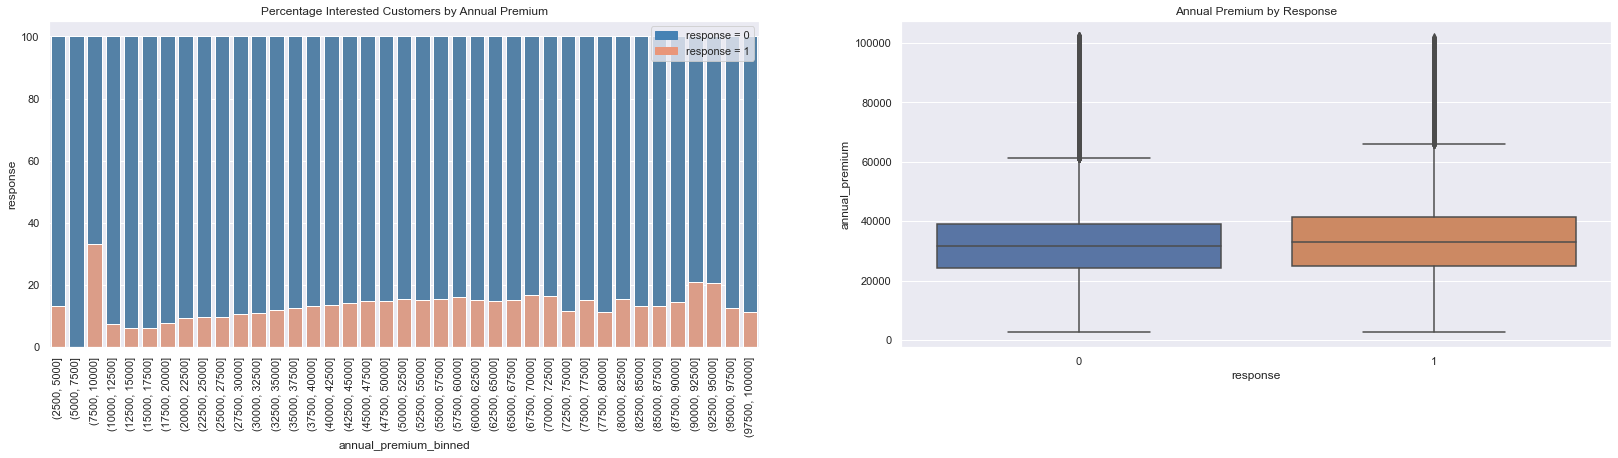

In [42]:
# filter for better vizualization in plot
aux1 = df4[df4['annual_premium'] <= 102500]

# define the annual_premium bins
bins = list(np.arange(2500, 102500, 2500))

# response is 0 or 1 (total)
aux2 = aux1[['annual_premium', 'response']]
aux2['annual_premium_binned'] = pd.cut(aux2['annual_premium'], bins=bins)
aux2 = aux2[['annual_premium_binned', 'response']].groupby('annual_premium_binned').count().reset_index()

# response is 1
aux3 = aux1[['annual_premium', 'response']]
aux3['annual_premium_binned'] = pd.cut(aux3['annual_premium'], bins=bins)
aux3 = aux3[['annual_premium_binned', 'response']].groupby('annual_premium_binned').sum().reset_index()

# convert response in percet annual_premium in relation to the total in aux3 and aux2
aux3['response'] = [i / j * 100 for i,j in zip(aux3['response'], aux2['response'])]
aux2['response'] = [i / j * 100 for i,j in zip(aux2['response'], aux2['response'])]

# plots
plt.figure(figsize=(28, 6))

# percent stacked barplot 
plt.subplot(1, 2, 1)

# bar chart 1 -> top bars (group of 'response = 0')
bar1 = sns.barplot(x='annual_premium_binned',  y='response', data=aux2, color='steelblue')

# bar chart 2 -> bottom bars (group of 'response = 1')
bar2 = sns.barplot(x='annual_premium_binned', y='response', data=aux3, color='darksalmon')

# add legend
top_bar = mpatches.Patch(color='steelblue', label='response = 0')
bottom_bar = mpatches.Patch(color='darksalmon', label='response = 1')
plt.legend(handles=[top_bar, bottom_bar])
plt.title('Percentage Interested Customers by Annual Premium')
plt.xticks(rotation = 90)

# boxplot
plt.subplot(1, 2, 2)
sns.boxplot( x='response', y='annual_premium', data=aux1)
plt.title('Annual Premium by Response');

Some bins for lower annual premiums have lower percentages of customers interested in car insurance, but the bin with the highest percentage of customers interested in car insurance refers to one of the lower annual premiums. In the rest of the bins the percentages of customers interested in car insurance have a slow variation, which does not validate our hypothesis, and but this variation indicates that the annual premium some how useful for the model.

### H10. Customers insured in health for a long time are more interested in the insurance than those insured for a shorter period.
**False.** The interested clients are equally distributed over different time values as health insurance clients (vintage).

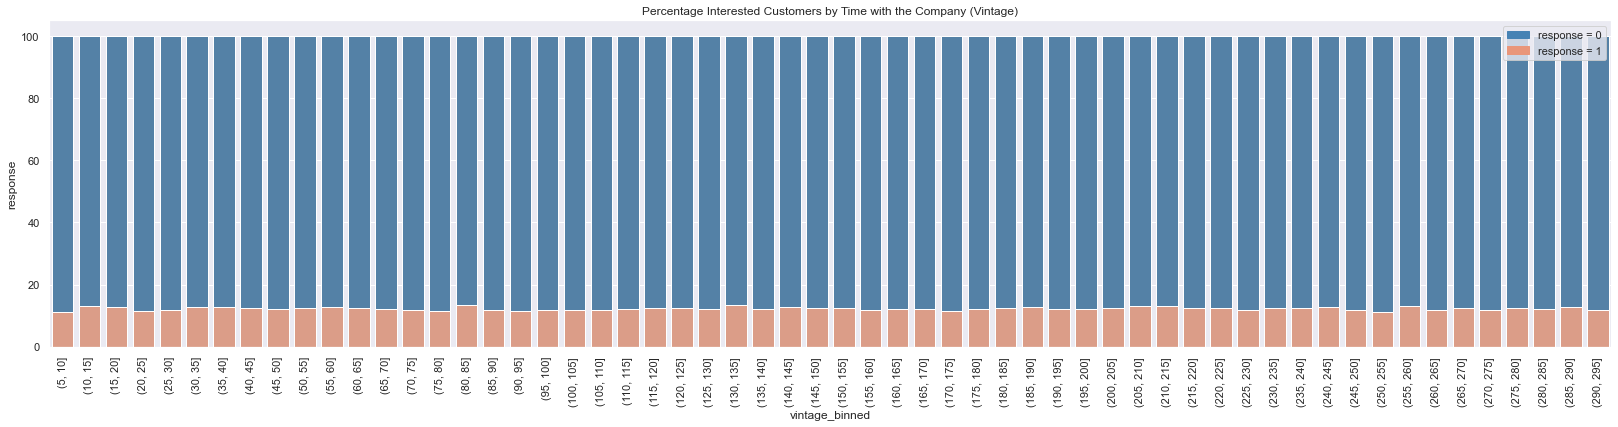

In [43]:
# define the vintage bins
bins = list(np.arange(5, 300, 5))

# response is 0 or 1 (total)
aux1 = df4[['vintage', 'response']]
aux1['vintage_binned'] = pd.cut(aux1['vintage'], bins=bins)
aux1 = aux1[['vintage_binned', 'response']].groupby('vintage_binned').count().reset_index()

# response is 1
aux2 = df4[['vintage', 'response']]
aux2['vintage_binned'] = pd.cut(aux2['vintage'], bins=bins)
aux2 = aux2[['vintage_binned', 'response']].groupby('vintage_binned').sum().reset_index()

# convert response in percet vintage in relation to the total in aux2 and aux1
aux2['response'] = [i / j * 100 for i,j in zip(aux2['response'], aux1['response'])]
aux1['response'] = [i / j * 100 for i,j in zip(aux1['response'], aux1['response'])]

# plots
plt.figure(figsize=(28, 6))

# percent stacked barplot 
# bar chart 1 -> top bars (group of 'response = 0')
bar1 = sns.barplot(x='vintage_binned',  y='response', data=aux1, color='steelblue')

# bar chart 2 -> bottom bars (group of 'response = 1')
bar2 = sns.barplot(x='vintage_binned', y='response', data=aux2, color='darksalmon')

# add legend
top_bar = mpatches.Patch(color='steelblue', label='response = 0')
bottom_bar = mpatches.Patch(color='darksalmon', label='response = 1')
plt.legend(handles=[top_bar, bottom_bar])
plt.title('Percentage Interested Customers by Time with the Company (Vintage)')
plt.xticks(rotation = 90);

Interested customers are equally distributed over different time values as health insurance customers (vintage), showing that our hypothesis is false. The variable vintage alone looks not useful for the model, since the distribution of interested and not interested in car insurance by bins is quite similar. 

## 4.3 Multivariate Analysis

The goal is not only to see the correlation between the response variable and the predictors, but also between the predictors themselves, to reduce the dimensionality of the model. 
If one variable is highly correlated with another you can take one of them out to reduce the dimensionality of the model. 

### 4.3.1 Numerical Variables

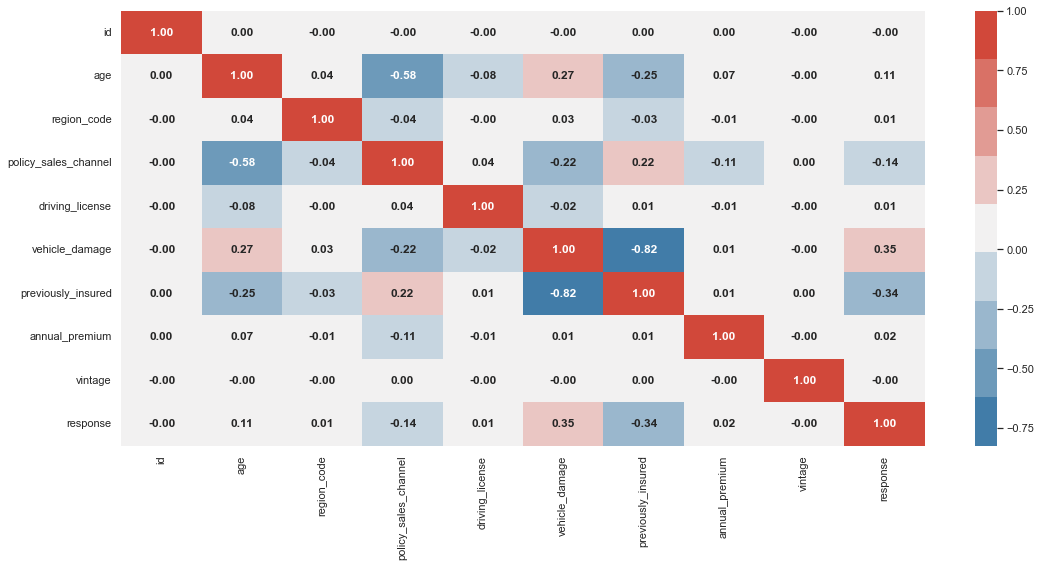

In [44]:
num_corr = df_num2.corr(method='pearson')

plt.figure(figsize=(18, 8))
color_palette  = sns.diverging_palette(240, 15, n=9)
sns.heatmap(num_corr, annot=True, annot_kws={'fontsize':'12', 'fontweight':'bold'}, fmt='.2f', cmap=color_palette);

* There is a strong negative correction between vehicle damage and previously insured (-0.82). 
* The second strongest correlation is between age and policy sales channel (-0.58). 
* Then there are the correlations between response and vehicle damage, which is lower than we actually thought (0.35), and response and previously insured, also lower than we thought (-0.34).

### 4.3.2 Categorical Variables

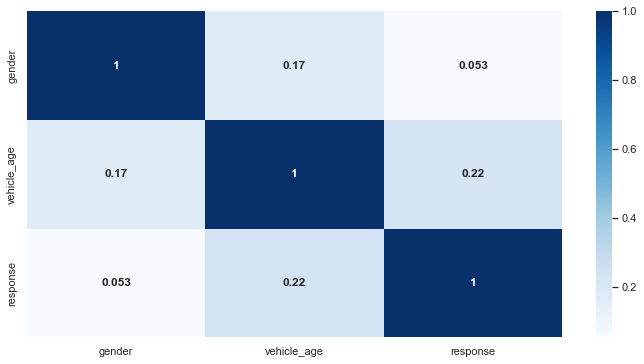

In [45]:
cat_corr = corr_matrix(df4, columns=['gender', 'vehicle_age', 'response'])

plt.figure(figsize=(12, 6))
sns.heatmap(data=cat_corr, annot=True, annot_kws={'fontsize':12, 'fontweight':'bold'}, cmap='Blues');

# 5 DATA PREPARATION

In [46]:
df5 = df4.copy()

## 5.1 Standardization

In [47]:
ss_annual_premium = pp.StandardScaler()

df5['annual_premium'] = ss_annual_premium.fit_transform(df5[['annual_premium']].values)
#pickle.dump(ss_annual_premium, open('../models/cycle1/parameters/annual_premium_scaler.pkl', 'wb'))

## 5.2 Rescaling

In [48]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

df5['age'] = mms_age.fit_transform(df5[['age']].values)
#pickle.dump(mms_age, open('../models/cycle1/parameters/age_scaler.pkl', 'wb'))

df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)
#pickle.dump(mms_vintage, open('../models/cycle1/parameters/vintage_scaler.pkl', 'wb'))

## 5.3 Encoding

In [49]:
# gender -> one hot encoding
df5 = pd.get_dummies(df5, prefix='gender', prefix_sep='_', columns=['gender'])

# vehicle_age -> one hot encoding
df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

# region_code -> target encoding
encodig_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(encodig_region_code)
#pickle.dump(encodig_region_code, open('../models/cycle1/parameters/region_code_scaler.pkl', 'wb'))

# policy_sales_channel -> frequency encoding
encodig_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(encodig_policy_sales_channel)
#pickle.dump(encodig_policy_sales_channel, open('../models/cycle1/parameters/policy_sales_channel_scaler.pkl', 'wb'))

## 5.4 Validation Preparation

In [50]:
df_valid = pd.read_csv('../data/df_valid.csv')

In [51]:
# annual premium
df_valid['annual_premium'] = ss_annual_premium.transform(df_valid[['annual_premium']].values)

# age
df_valid['age'] = mms_age.transform(df_valid[['age']].values)

# vintage
df_valid['vintage'] = mms_vintage.transform(df_valid[['vintage']].values)

# gender
df_valid = pd.get_dummies(df_valid, prefix='gender', prefix_sep='_', columns=['gender'])

# vehicle_age
df_valid = pd.get_dummies(df_valid, prefix='vehicle_age', columns=['vehicle_age'])

# region_code
df_valid.loc[:, 'region_code'] = df_valid['region_code'].map(encodig_region_code)

# policy_sales_channel 
df_valid.loc[:, 'policy_sales_channel'] = df_valid['policy_sales_channel'].map(encodig_policy_sales_channel)

## 5.5 Separating X and y

In [52]:
# training data
X_train_full = df5.drop(columns=['response', 'id'])
y_train     = df5['response'].copy()

# validation data
X_valid_full = df_valid.drop(columns=['response', 'id'])
y_valid     = df_valid['response'].copy()

We will run the machine learning models fisrt without balancing the data by response variable, if it performs very badly, we move on to balancing. Balancing techniques is an attempt to improve performance, so it is important to have a previous performance reference.

# 6 FEATURES SELECTION

## 6.1 Select From Model + Extra Trees

In [53]:
X_train_sfm = X_train_full
y_train_sfm = y_train

etc = ExtraTreesClassifier(n_jobs=-1)
sfm = SelectFromModel(etc)

sfm.fit(X_train_sfm, y_train_sfm);

In [54]:
cols_selected_sfm = sfm.get_support()
columns_selected = X_train_full.loc[:, cols_selected_sfm].columns.tolist()

columns_selected

['age', 'region_code', 'annual_premium', 'vintage']

In [55]:
columns_selected_sfm = ['age', 'region_code', 'annual_premium', 'vintage']

## 6.2 Feature Importances + Extra Tree

In [56]:
X_train_fimp = X_train_full
y_train_fimp = y_train 

fimp = ExtraTreesClassifier(n_jobs=-1)

fimp.fit(X_train_fimp, y_train_fimp);

                         feature  importance
7                        vintage        0.27
6                 annual_premium        0.24
0                            age        0.17
1                    region_code        0.10
4                 vehicle_damage        0.08
2           policy_sales_channel        0.06
5             previously_insured        0.05
10      vehicle_age_below_1_year        0.01
11  vehicle_age_between_1_2_year        0.01
12      vehicle_age_over_2_years        0.00
9                    gender_Male        0.00
8                  gender_Female        0.00
3                driving_license        0.00


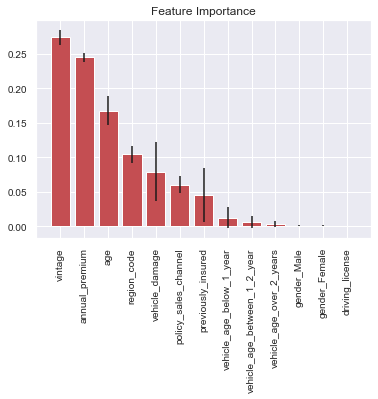

In [57]:
features_ranking = pd.DataFrame(zip(X_train_full.columns, fimp.feature_importances_)).rename(columns={0:'feature', 1:'importance'}).sort_values('importance', ascending=False)
print(features_ranking)

skplt.estimators.plot_feature_importances(fimp, feature_names=X_train_full.columns.tolist());
plt.xticks(rotation=90)
plt.plot();

Although, features related to the age of the vehicle appear of low importance, I will risk including them because of what was visualized in the EDA.

## 6.4 Selected Features

In [58]:
selected_cols = list(features_ranking['feature'][:10])

X_train = X_train_full[selected_cols]
X_valid = X_valid_full[selected_cols]

# 7 MACHINE LEARNING MODELLING

In this project, our goal is not just to identify customers who would buy car insurance. In fact, we want to rank these people according to their probability of purchasing the car insurance. In other words, we need to build an ordered list starting with the customers most likely to purchase the insurance. That said, our problem is a Learning to Rank problem. For evaluation, we will use the following metrics: Cumulative Gain Curve, Lift Curve, Precision, and Recall.

**Cumulative Gains Curve:** shows the percentage of targets achieved by considering a certain percentage of the population with the highest probability of being targeted according to the model.

**Lift Curve:** measures how much better our model is compared to a random model.

**Precision:** percentage of interested customers in the top k (up to the line I want from the ordination, in our problem, the first 20,000 customers), that our model classified as high probability and were actually interested in car insurance.

**Recall:** percentage of the total interested customers that our top-k model selected as high probability.

## 7.1 Single Performace

In [59]:
# metrics at 20% of validation data
k = np.ceil(len(X_valid) * 0.2)

### 7.1.1 Logistic Regression

,Model,Precision,Recall
0,Logistic Regression,0.34,0.55


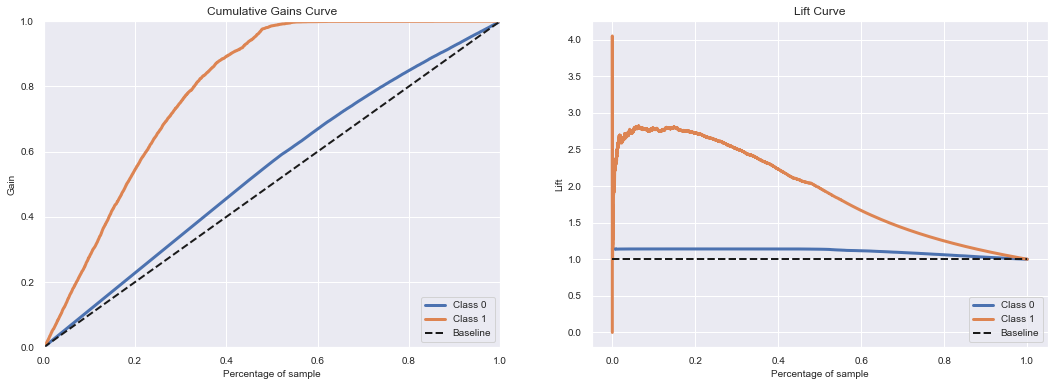

In [60]:
# model
lr = LogisticRegression(max_iter=200, random_state=11)

# model training
lr.fit(X_train, y_train)

# model prediction
yhat_lr = lr.predict_proba(X_valid)
            
# metrics at 20%
metrics_at_20perc_lr = metrics_at_k(X_valid, y_valid, yhat_lr, 'Logistic Regression', k=k)
display(metrics_at_20perc_lr)

# cumulative gain curve and lift curve
fig, axs = plt.subplots(ncols=2, figsize=(18, 6))
skplt.metrics.plot_cumulative_gain(y_valid, yhat_lr, ax=axs[0])
skplt.metrics.plot_lift_curve(y_valid, yhat_lr, ax=axs[1]);

### 7.1.2 KNN

,Model,Precision,Recall
0,KNN,0.37,0.60


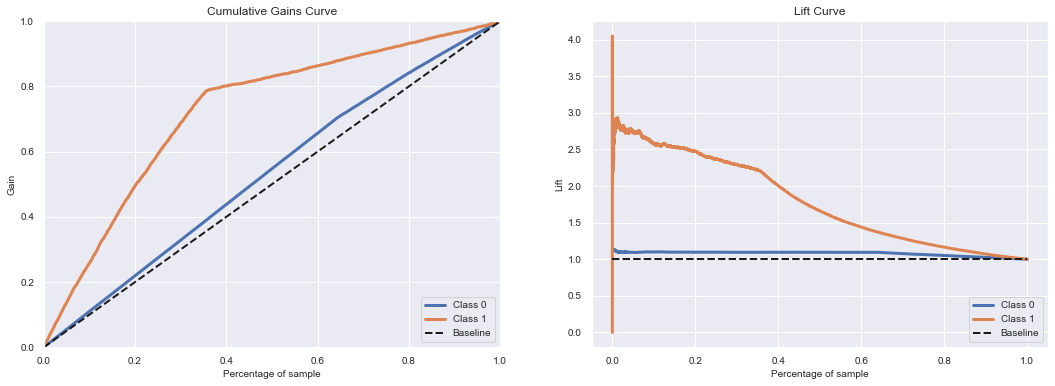

In [61]:
# model
knn = KNeighborsClassifier(n_neighbors=5)

# model training
knn.fit(X_train, y_train)

# model prediction
yhat_knn = knn.predict_proba(X_valid)
            
# metrics at 20%
metrics_at_20perc_knn = metrics_at_k(X_valid, y_valid, yhat_knn, 'KNN', k=k)
display(metrics_at_20perc_knn)

# cumulative gain curve and lift curve
fig, axs = plt.subplots(ncols=2, figsize=(18, 6))
skplt.metrics.plot_cumulative_gain(y_valid, yhat_knn, ax=axs[0])
skplt.metrics.plot_lift_curve(y_valid, yhat_knn, ax=axs[1]);

### 7.1.3 Randon Forest

,Model,Precision,Recall
0,Random Forest,0.33,0.54


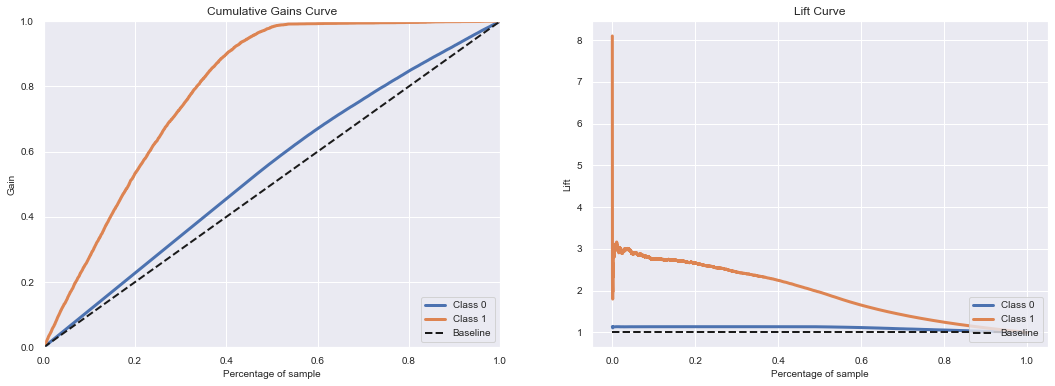

In [62]:
# model
rf = RandomForestClassifier(random_state=11)

# model training
rf.fit(X_train, y_train)

# model prediction
yhat_rf = rf.predict_proba(X_valid)

# metrics at 20%
metrics_at_20perc_rf = metrics_at_k(X_valid, y_valid, yhat_rf, 'Random Forest', k=k)
display(metrics_at_20perc_rf)

# cumulative gain curve and lift curve
fig, axs = plt.subplots(ncols=2, figsize=(18, 6))
skplt.metrics.plot_cumulative_gain(y_valid, yhat_rf, ax=axs[0])
skplt.metrics.plot_lift_curve(y_valid, yhat_rf, ax=axs[1]);

In [63]:
### 7.1.4 LGBM

,Model,Precision,Recall
0,LGBM,0.36,0.58


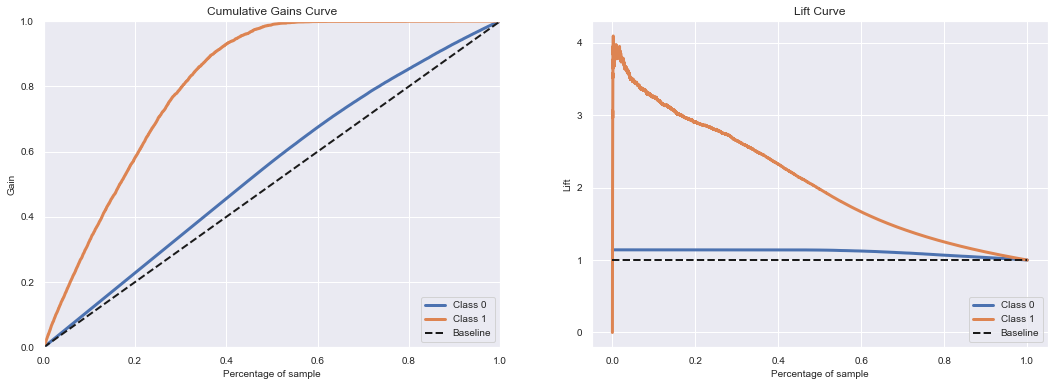

In [64]:
# model
lgbm = LGBMClassifier(random_state=11)

# model training
lgbm.fit(X_train, y_train)

# model prediction
yhat_lgbm = lgbm.predict_proba(X_valid)

# metrics at 20%
metrics_at_20perc_lgbm = metrics_at_k(X_valid, y_valid, yhat_lgbm, 'LGBM', k=k)
display(metrics_at_20perc_lgbm)

# cumulative gain curve and lift curve
fig, axs = plt.subplots(ncols=2, figsize=(18, 6))
skplt.metrics.plot_cumulative_gain(y_valid, yhat_lgbm, ax=axs[0])
skplt.metrics.plot_lift_curve(y_valid, yhat_lgbm, ax=axs[1]);

## 7.2 Cross Validation

In [65]:
X_cv = pd.concat([X_train, X_valid], axis=0).reset_index(drop=True)
y_cv = pd.concat([y_train, y_valid], axis=0).reset_index(drop=True)

nfold = 10

# metrics at 20% of validation data
k_cv = np.ceil((len(X_cv)/nfold) * 0.2)

### 7.2.1 Logistic Regression

In [66]:
cv_at_20perc_lr = cross_validation(X_cv, y_cv, lr, 'Logistic Regression', nfold=10, k=k_cv, verbose=False)
cv_at_20perc_lr

,Model,Precision,Recall
0,Logistic Regression,0.33 +/- 0.0034,0.54 +/- 0.0055


### 7.2.2 KNN

In [67]:
cv_at_20perc_knn = cross_validation(X_cv, y_cv, knn, 'KNN', nfold=10, k=k_cv, verbose=False)
cv_at_20perc_knn 

,Model,Precision,Recall
0,KNN,0.37 +/- 0.0121,0.61 +/- 0.0197


### 7.2.3 Randon Forest

In [68]:
cv_at_20perc_rf = cross_validation(X_cv, y_cv, rf, 'Random Forest', nfold=10, k=k_cv, verbose=False)
cv_at_20perc_rf

,Model,Precision,Recall
0,Random Forest,0.33 +/- 0.003,0.53 +/- 0.0049


### 7.2.4 LGBM

In [69]:
cv_at_20perc_lgbm = cross_validation(X_cv, y_cv, lgbm, 'LGBM', nfold=10, k=k_cv, verbose=False)
cv_at_20perc_lgbm

,Model,Precision,Recall
0,LGBM,0.35 +/- 0.0047,0.58 +/- 0.0076


## 7.3 Performance Comparison

### 7.3.1 Single Performance

In [70]:
results_at_20perc = pd.concat([metrics_at_20perc_lr, metrics_at_20perc_knn, metrics_at_20perc_rf, metrics_at_20perc_lgbm]).reset_index(drop=True)
results_at_20perc

,Model,Precision,Recall
0,Logistic Regression,0.34,0.55
1,KNN,0.37,0.60
2,Random Forest,0.33,0.54
3,LGBM,0.36,0.58


### 7.3.2 Real Performance - Cross Validation

In [72]:
cv_results_at_20perc = pd.concat([cv_at_20perc_lr, cv_at_20perc_knn, cv_at_20perc_rf, cv_at_20perc_lgbm]).reset_index(drop=True)
cv_results_at_20perc

,Model,Precision,Recall
0,Logistic Regression,0.33 +/- 0.0034,0.54 +/- 0.0055
1,KNN,0.37 +/- 0.0121,0.61 +/- 0.0197
2,Random Forest,0.33 +/- 0.003,0.53 +/- 0.0049
3,LGBM,0.35 +/- 0.0047,0.58 +/- 0.0076


For this problem, we consider Precision more important than Recall, since we are interested that the model hitting as many values as possible in the window of values up to k. From here on we will go with the KNN model, as it performed better for Precision and also for Recall.

# 8 HYPERPARAMETER FINE TUNNING

## 8.1 Random Search

In [73]:
##----------------------------------------------------------
## it was commented because boruta takes a long time to run
##----------------------------------------------------------
#
## selecting the possible parameters to be taken
#param = {'n_neighbors': list(range(5, 16)),
#         'p': [1, 2]}
#
#MAX_EVAL = 8  # number of iterations of tuning
#
#final_result = pd.DataFrame()
#
#for i in range(MAX_EVAL):
#    
#    # choose values for parameters randomly
#    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}  # .items returns the items (key-values) of a dictionary
#    print(hp)
#    
#    # model
#    knn_tunning = KNeighborsClassifier(n_neighbors=hp['n_neighbors'], p=hp['p'], n_jobs=-1)
#    
#
#    # performance
#    result = cross_validation(X_cv, y_cv, knn_tunning, 'KNN', nfold=10, k=k_cv, verbose=True)
#    final_result = pd.concat([final_result, result])
#    
#final_result
#
##---------------------
## best n_neighbors: 8
## best p: 1
##---------------------